<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_4/CutMix_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torch.utils.data import Dataset
import random as rand
import matplotlib.pyplot as plt
import numpy as np
import PIL

Define CutMix class. It can accept both a PIL image (basically transform mode) or an integer label (basically target transform mode). It should be possible to compose it with other transforms, but all previously applied transforms must be known to the dataset passed to CutMix.

The image and target transform objects must be different instances of this class, and they need to share an rng, which is possible by manually seeding it. That is the core idea of this approach.

The main constraint is that CutMix must know its underlying dataset, and the underlying dataset must know its number of classes. Also, all dataset images must have, or be previously transformed to have, the same sizes. It is not possible to apply consecutive CutMix operations, but this would not make sense. Unfortunately, CutMix cannot be wrapped in something like RandomApply().

In [2]:
class CutMix:
  # implemented according to pseudocode from https://arxiv.org/pdf/1905.04899.pdf
    def __init__(self, dataset: Dataset, seed: int, num_classes: int = 0):
        self.rng = np.random.default_rng(seed)
        self.dataset = dataset
        self.ToTensor = transforms.ToTensor()
        self.ToPIL = transforms.ToPILImage()
        self.len = len(self.dataset)
        if num_classes <= 0:
            self.num_classes = len(self.dataset.classes)
        else:
            self.num_classes = num_classes
        test_image, _ = dataset.__getitem__(0)
        self.W, self.H = test_image.size

    def __call__(self, sample):
        # shared non-determinism between image and label CutMix
        lam = self.rng.random()
        r_x = self.rng.random()*self.W
        r_y = self.rng.random()*self.H
        # the following two lines correct a typo in the paper pseudocode
        r_w = np.sqrt(1-lam)*self.W
        r_h = np.sqrt(1-lam)*self.H

        x_1 = int(np.round(np.max([r_x-r_w/2,0])))
        x_2 = int(np.round(np.min([r_x+r_w/2,self.W])))
        y_1 = int(np.round(np.max([r_y-r_h/2,0])))
        y_2 = int(np.round(np.min([r_y+r_h/2,self.H])))
        # since we apply CutMix element-wise, replace batch shuffle by this
        mix_ind = self.rng.integers(self.len, endpoint=False)
        image_s, label_s = self.dataset.__getitem__(mix_ind)

        # what to do when the sample is an image
        if isinstance(sample, PIL.Image.Image):
            image = self.ToTensor(sample)
            image_s = self.ToTensor(image_s)
            image[:, y_1:y_2, x_1:x_2] = image_s[:, y_1:y_2, x_1:x_2]
            image = self.ToPIL(image)
            return image

        # what to do when the sample is an index
        else:
            label = sample
            label = torch.Tensor([label]).long()
            label = F.one_hot(label, num_classes=self.num_classes).squeeze()
            label_s = torch.Tensor([label_s]).long()
            label_s = F.one_hot(label_s, num_classes=self.num_classes).squeeze()
            lam_true = 1 - (x_2 - x_1) * (y_2 - y_1) / (self.H * self.W)
            return lam_true * label + (1 - lam_true) * label_s

#### Demonstrate usage on STL10

In [3]:
random_random_seed = np.random.randint(1e10)
print('The shared random seed is', random_random_seed)

train_transforms_before = transforms.Compose(
    [
    ])
trainset_before = dsets.STL10('data', split='train', download=True, transform=train_transforms_before)

transform_train = transforms.Compose(
    [CutMix(dataset=trainset_before, seed=random_random_seed),
     transforms.ToTensor(),
     ])
target_transforms = transforms.Compose(
    [CutMix(dataset=trainset_before, seed=random_random_seed)
    ])
trainset = dsets.STL10('data', split='train',download=True, transform=transform_train, target_transform=target_transforms)

The shared random seed is 4885133781
Files already downloaded and verified
Files already downloaded and verified


This image is 83.63715362548828 percent airplane and 16.36284828186035 percent monkey!


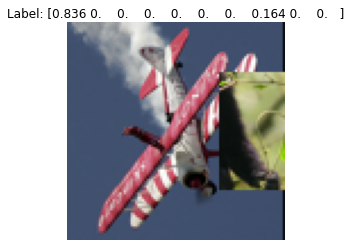

In [4]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()

This image is 61.63194274902344 percent truck and 38.3680534362793 percent horse!


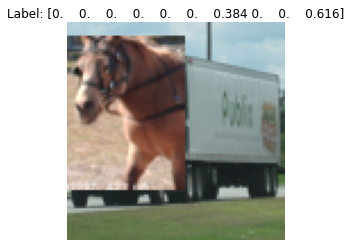

In [5]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()

This image is 56.640625 percent bird and 43.359375 percent horse!


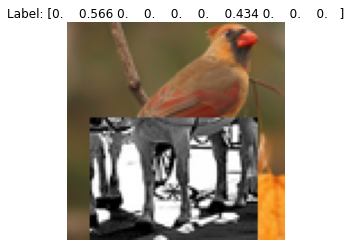

In [6]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()

Has science gone too far?

#### Demonstrate usage on CIFAR10 - Apply ColorJitter, then CutMix, then RandomVerticalFlip (just to show that compositions can work)

In [7]:
random_random_seed = np.random.randint(1e10)
print('The shared random seed is', random_random_seed)

train_transforms_before = transforms.Compose(
    [transforms.ColorJitter()
    ])
trainset_before = dsets.CIFAR10('data', train=True, download=True, transform=train_transforms_before)

transform_train = transforms.Compose(
    [transforms.ColorJitter(),
     CutMix(dataset=trainset_before, seed=random_random_seed),
     transforms.RandomVerticalFlip(p=1.),
     transforms.ToTensor()
     ])
target_transforms = transforms.Compose(
    [CutMix(dataset=trainset_before, seed=random_random_seed)
    ])
trainset = dsets.CIFAR10('data', train=True, download=True, transform=transform_train, target_transform=target_transforms)

The shared random seed is 1954769841
Files already downloaded and verified
Files already downloaded and verified


This image is 100.0 percent ship and 0.0 percent truck!


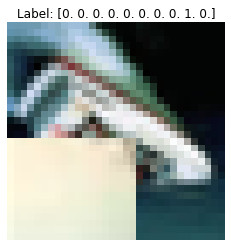

In [8]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()

This image is 100.0 percent automobile and 0.0 percent truck!


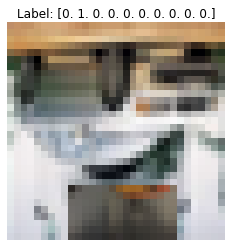

In [9]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()

This image is 93.5546875 percent truck and 6.4453125 percent deer!


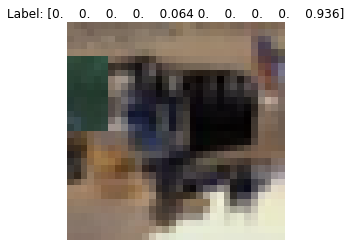

In [10]:
rand_image = np.random.randint(len(trainset)+1)
image, label = trainset.__getitem__(rand_image)
sorted_args = label.argsort().squeeze()
print(f'This image is {label[sorted_args[-1]]*100} percent {trainset.classes[sorted_args[-1]]} and {label[sorted_args[-2]]*100} percent {trainset.classes[sorted_args[-2]]}!')
plt.imshow(image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Label: ' + str(np.round(label.cpu().numpy(),3)))
plt.show()